In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

In [82]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression


In [83]:
cust_data = pd.read_csv("datasets\\anon_cust_data.csv", index_col=[0])

In [84]:
cust_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [85]:
cust_data.columns

Index(['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure',
       'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod',
       'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

In [86]:
y_orig = cust_data["Churn"]
X_orig = cust_data.iloc[:, 0:-1]
X_orig.head(3)

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15


In [87]:
y = y_orig.copy()
X = X_orig.copy()

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=99)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=99)
print(X.shape)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(7043, 19)
(4225, 19)
(1409, 19)
(1409, 19)


In [105]:
cat_feature_list = X_train.select_dtypes(include='object').columns.tolist()
num_feature_list = X_train.select_dtypes(exclude='object').columns.tolist()

cat_transformer = Pipeline(
    steps=[('oh_encoder', OneHotEncoder(drop='first', handle_unknown='ignore'))]
)

num_transformer = Pipeline(
    steps=[("scaler", StandardScaler())]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("cat", cat_transformer, cat_feature_list),
        ("num", num_transformer, num_feature_list)
    ]
)

clf = Pipeline(
    steps=[("preprocessor", preprocessor), ("classifier", LogisticRegression(max_iter=1000))]
)

In [108]:
clf.fit(X_train, y_train)
print(clf.score(X_train, y_train))
print(clf.score(X_test, y_test))


0.8762130177514793
0.7977288857345636


c:\Users\Chad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [121]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from sklearn.metrics import auc, roc_curve, roc_auc_score

In [122]:
clf_predicted = clf.predict(X_test)
conf_matrix = confusion_matrix(y_test, clf_predicted)
conf_matrix

c:\Users\Chad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


array([[920, 106],
       [179, 204]], dtype=int64)

In [123]:
class_report = classification_report(y_test, clf_predicted)
print(class_report)

              precision    recall  f1-score   support

          No       0.84      0.90      0.87      1026
         Yes       0.66      0.53      0.59       383

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



In [130]:
proba = clf.predict_log_proba(X_test)

predictions = proba[:, 1]

print(y_test.head())

4922    No
1426    No
4705    No
4048    No
48      No
Name: Churn, dtype: object


c:\Users\Chad\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [15] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


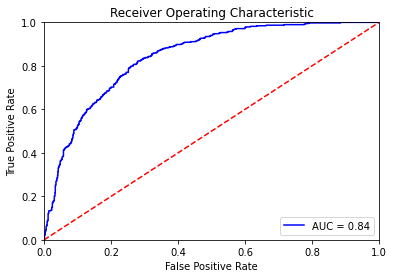

In [131]:
fpr, tpr, threshold = roc_curve(y_test, predictions, pos_label="Yes")
roc_auc = auc(fpr, tpr)

import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()